<a href="https://colab.research.google.com/github/virgoaugustine/policy-interventions-covid19/blob/master/change_point_analysis_Ghana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Priesemann-Group/covid19_inference/blob/model_cleanup/scripts/interactive/example_one_bundesland.ipynb)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!pip install git+https://github.com/Priesemann-Group/covid19_inference.git

  Cloning https://github.com/Priesemann-Group/covid19_inference.git to /tmp/pip-req-build-b6uam_zy
  Running command git clone -q https://github.com/Priesemann-Group/covid19_inference.git /tmp/pip-req-build-b6uam_zy
  Created wheel for covid19-inference: filename=covid19_inference-0.1.8a0-cp36-none-any.whl size=103637 sha256=b4077b96db03296fa322f6813e81de351cd9542df85f947435ab3e2d7f3abe4b
  Stored in directory: /tmp/pip-ephem-wheel-cache-yvy5uon4/wheels/da/f1/e7/da56ba4fe019b70927b4bb10088f02f672b31b69fd54a6e613
Successfully built covid19-inference


In [347]:
import datetime
import time as time_module
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import theano
import theano.tensor as tt
import pymc3 as pm

import pickle

In [348]:
# Now to the fun stuff, we import our module!
try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../../")
    import covid19_inference as cov19


## Download the data

Load Ghana's COVID19 data from John Hopkins University (JHU)



In [349]:
jhu = cov19.data_retrieval.JHU()  # It is important to download the dataset!
jhu.download_all_available_data()
# One could also parse True to the constructor of the class to force an auto download

INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local


In [351]:
#Ghana's first case was on March 14, 2020

bd = datetime.datetime(2020, 3, 14)  # For the date filter
ed = datetime.datetime.now()

In [350]:
total_cases = jhu.get_total(value="confirmed", country='Ghana', data_begin=bd, data_end=ed)
new_cases = jhu.get_new(value="confirmed", country='Ghana', data_begin=bd, data_end=ed)

Plot the results returned to see if it makes sense

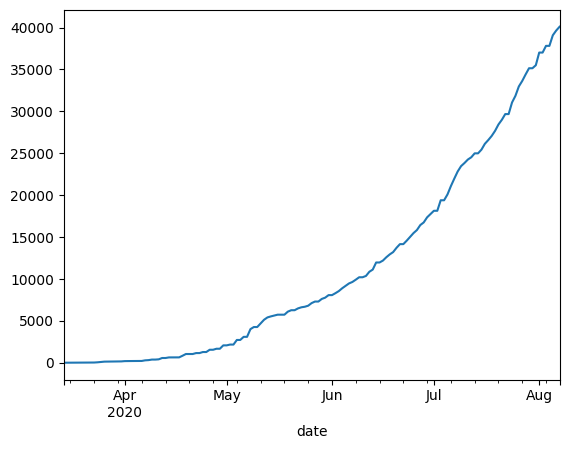

In [352]:
total_cases.plot()

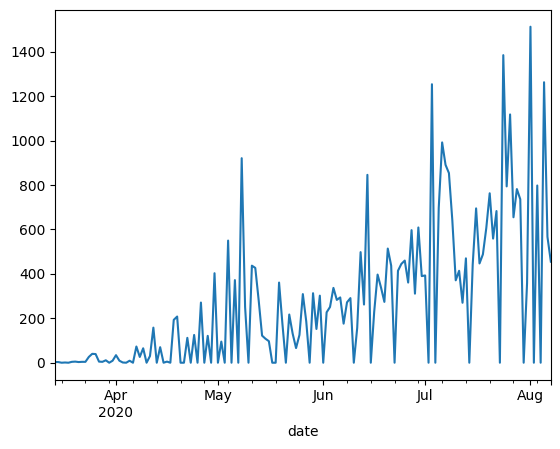

In [353]:
new_cases.plot()

## Pre-process the data

Filter selection date to start from when the cases reached 100 in Ghana

In [354]:
total_cases.isnull().sum() # This returned 0 meaning there are no NaN values in this dataframe.

0

In [355]:
cases_100 = total_cases[total_cases >=100]
cases_100

date
2020-03-26      132
2020-03-27      137
2020-03-28      141
2020-03-29      152
2020-03-30      152
              ...  
2020-08-03    37812
2020-08-04    37812
2020-08-05    39075
2020-08-06    39642
2020-08-07    40097
Name: confirmed, Length: 135, dtype: int64

- We will check for missing dates between cases_100 here.

In [356]:
# date_range = pd.date_range(start = cases_100.index[0], end = cases_100.index[-1])

# missing_dates = date_range.difference(cases_100.index) 
# #Found some missing dates. We will fill in those missing dates and fill the values with 0

# cases_100 = cases_100.reindex(date_range, fill_value=0)




## Splitting the data into a training set and validation set

In [357]:
train_set = cases_100[cases_100.index <= '2020-07-25']
val_set = cases_100[(cases_100.index > '2020-07-25')]


In [358]:
val_set

date
2020-07-26    32969
2020-07-27    33624
2020-07-28    34406
2020-07-29    35142
2020-07-30    35142
2020-07-31    35501
2020-08-01    37014
2020-08-02    37014
2020-08-03    37812
2020-08-04    37812
2020-08-05    39075
2020-08-06    39642
2020-08-07    40097
Name: confirmed, dtype: int64



## Create the model

First we need to set the priors for the change points and other configs.


In [359]:
diff_data_sim = 16  # should be significantly larger than the expected delay, in
# order to always fit the same number of data points.
num_days_forecast = 10

#### Dates Chosen
- March 30,2020. Partial Lockdown effected
- June 15, 2020. Compulsory wearing of face masks.
- July 26, 2020. 


In [360]:
# We set the priors for the changepoints here
prior_date_mild_dist_begin = datetime.datetime(2020, 3, 30)
prior_date_strong_dist_begin = datetime.datetime(2020, 6, 15)
prior_date_contact_ban_begin = datetime.datetime(2020, 7, 26)

In [361]:
change_points = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_contact_ban_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8 / 2,
        pr_sigma_lambda=1,
    ),
]



Next, we create the model! There are default values for most of the function arguments,
but we will try to explicitly set all kwargs for the sake of this example.

- Ghana's population as at 2020 stands at about 31,072,940 million people.



In [369]:
params_model = dict(
    new_cases_obs=train_set[:],
    data_begin=train_set.index[0],
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=31072940,
)
# Median of the prior for the delay in case reporting, we assume 10 days
pr_delay = 3



The model is specified in a context. Each function in this context
has access to the model parameters set.


In [370]:
with cov19.model.Cov19Model(**params_model) as this_model:
    # Create an array of the time dependent infection rate lambda
    lambda_t_log = cov19.model.lambda_t_with_sigmoids(
        pr_median_lambda_0=0.4,
        pr_sigma_lambda_0=0.5,
        change_points_list=change_points,  # The change point priors we constructed earlier
        name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
    )

    # set prior distribution for the recovery rate
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # This builds a decorrelated prior for I_begin for faster inference.
    # It is not necessary to use it, one can simply remove it and use the default argument
    # for pr_I_begin in cov19.SIR
    prior_I = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log,
        mu=mu,
        pr_median_delay=pr_delay,
        name_I_begin="I_begin",
        name_I_begin_ratio_log="I_begin_ratio_log",
        pr_sigma_I_begin=2,
        n_data_points_used=5,
    )

    # Use lambda_t_log and mu to run the SIR model
    new_cases = cov19.model.SIR(
        lambda_t_log=lambda_t_log,
        mu=mu,
        name_new_I_t="new_I_t",
        name_I_t="I_t",
        name_I_begin="I_begin",
        pr_I_begin=prior_I,
    )

    # Delay the cases by a lognormal reporting delay
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        name_cases="delayed_cases",
        name_delay="delay",
        name_width="delay-width",
        pr_mean_of_median=pr_delay,
        pr_sigma_of_median=0.2,
        pr_median_of_width=0.3,
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(
        cases=new_cases,
        name_cases="new_cases",
        name_weekend_factor="weekend_factor",
        name_offset_modulation="offset_modulation",
        week_modulation_type="abs_sine",
        pr_mean_weekend_factor=0.3,
        pr_sigma_weekend_factor=0.5,
        weekend_days=(6, 7),
    )

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(new_cases)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


In [372]:
this_model.sim_len

148


## MCMC sampling

After the model is built, it is sampled using an MCMC sampler.
The number of parallel runs can be set with the argument `cores=`.
In particular, due to a bug in Theano, Windows users should set `cores=1`.
The sampling can take a long time.

- 2 cores running 200 draws each. A total of 400 draws


In [ ]:
trace = pm.sample(model=this_model, tune=350, draws=200, init="advi+adapt_diag", cores=2)


Only 300 samples in chain.
WARNING  [pymc3] Only 300 samples in chain.
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
INFO     [theano.gof.compilelock] Refreshing lock /root/.theano/compiledir_Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
Average Loss = 2,336.7:   1%|          | 1088/200000 [00:10<32:24, 102.31it/s]
Interrupted at 1,088 [0%]: Average Loss = 2,351.7
INFO     [pymc3.variational.inference] Interrupted at 1,088 [0%]: Average Loss = 2,351.7
Multiprocess sampling (2 chains in 2 jobs)
INFO     [pymc3] Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_log, delay_log, I_begin_ratio_log, mu, transient_len_2_log_, transi

### Save Trace Result to Pickle

In [ ]:

pickle_out = open("trace-3pm.pickle","wb")
pickle.dump(trace, pickle_out)
pickle_out.close()

## Load Trace result from pickle

In [ ]:

pickle_in = open("trace.pickle","rb")
trace= pickle.load(pickle_in)

In [ ]:
trace

<MultiTrace: 2 chains, 100 iterations, 36 variables>



## Plotting
Plotting tools are rudimentary right now. But one can always write custom plotting function
by accessing the samples stored in the trace.

### Distributions


['lambda_0_log_', 'lambda_1_log_', 'lambda_2_log_', 'lambda_3_log_', 'transient_day_1', 'transient_day_2', 'transient_day_3', 'transient_len_1_log_', 'transient_len_2_log_', 'transient_len_3_log_', 'mu', 'I_begin_ratio_log', 'delay_log', 'weekend_factor_log', 'offset_modulation_rad_circular__', 'sigma_obs']


INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
INFO     [theano.gof.compilelock] Refreshing lock /root/.theano/compiledir_Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


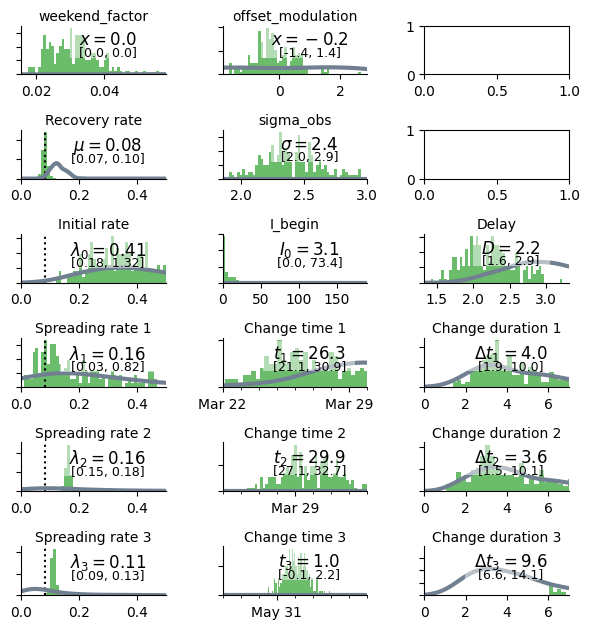

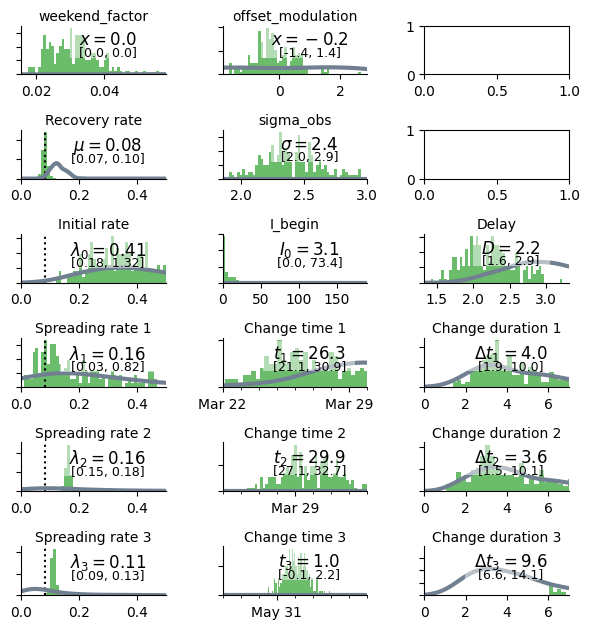

In [340]:

fig, axes = plt.subplots(6, 3, figsize=(6, 6.4))

# Get the free Random Variables
varnames = this_model.untransformed_freeRVs
print(varnames)

# Plot them
for i, key in enumerate(
    # left column
    ["weekend_factor", "mu", "lambda_0", "lambda_1", "lambda_2", "lambda_3"]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i, 0])

for i, key in enumerate(
    # mid column
    [
        "offset_modulation",
        "sigma_obs",
        "I_begin",
        "transient_day_1",
        "transient_day_2",
        "transient_day_3",
    ]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i, 1])

for i, key in enumerate(
    # right column
    ["delay", "transient_len_1", "transient_len_2", "transient_len_3",]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i + 2, 2])

fig.tight_layout()
fig


### Timeseries
timeseries overview, for now needs an offset variable to get cumulative cases


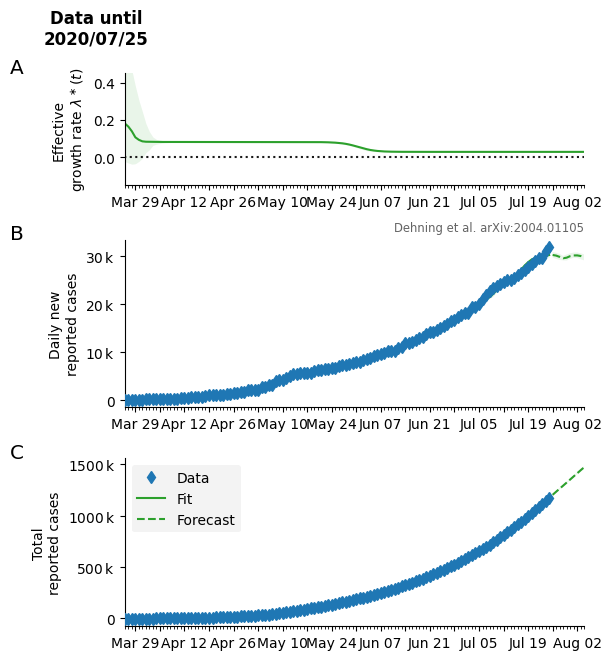

In [373]:
fig, axes = cov19.plot.timeseries_overview(this_model, trace, offset=-3000)


In [ ]:
fig2, axes2 = cov19.plot.timeseries_overview(this_model, trace, start=this_model.fcast_begin, end=this_model.fcast_end, offset=total_cases[0])

WARNING  [matplotlib.ticker] Locator attempting to generate 105094 ticks ([1988.0, ..., 737639.0]), which exceeds Locator.MAXTICKS (1000).


KeyboardInterrupt: ignored

WARNING  [matplotlib.ticker] Locator attempting to generate 105094 ticks ([1988.0, ..., 737639.0]), which exceeds Locator.MAXTICKS (1000).


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f9cd83eb268> (for post_execute):


KeyboardInterrupt: ignored

WARNING  [matplotlib.ticker] Locator attempting to generate 105094 ticks ([1988.0, ..., 737639.0]), which exceeds Locator.MAXTICKS (1000).
WARNING  [matplotlib.ticker] Locator attempting to generate 105094 ticks ([1988.0, ..., 737639.0]), which exceeds Locator.MAXTICKS (1000).
WARNING  [matplotlib.ticker] Locator attempting to generate 735654 ticks ([1988.0, ..., 737641.0]), which exceeds Locator.MAXTICKS (1000).
